# Jet data with Classical DNN

## Import and Connecting to Google

In [10]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/QML_project/jet_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/QML_project/jet_data


In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Dataset and NN

In [12]:
class JetDataset(Dataset):
    def __init__(self, x_name, y_name, number):
        with open(x_name, 'r') as f:
            x_data = np.load(x_name)
        with open(y_name, 'r') as f:
            y_data = np.load(y_name)
        
        random_index = np.random.permutation(len(y_data))

        self.x = torch.FloatTensor(x_data[random_index][:number].astype(float))
        self.y = torch.FloatTensor(y_data[random_index][:number].astype(float))
        print(f'x_name shape: {(self.x).shape} | y shape: {(self.y).shape}')
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

In [13]:
class JetDNN(nn.Module):
    def __init__(self, dimension, neuron_num_list):
        super(JetDNN, self).__init__()
        nodes  = [dimension]+neuron_num_list+[1]
        layers = []
        for i in range(len(nodes)-1):
            layers.append(nn.Linear(nodes[i], nodes[i+1]))
            layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        # x = torch.FloatTensor(x)
        return (self.net(x)).squeeze()

In [14]:
def Accuracy(y_pred, y_true):
    return sum(y_pred == y_true)/len(y_true)

In [15]:
def Jet_train(model, config, train_DL, test_DL, device):
    opt = getattr(torch.optim, config['opt'])(model.parameters(), **config['opt_hyper'])
    train_accs = []
    test_accs  = []
    epoch = 0
    best_test_acc = 0
    counter = 0
    while epoch < config['epochs'] and counter < config['early_stop']:
        epoch += 1

        # training
        model.train()
        train_loss = 0
        train_pred = []
        for x_batch, y_batch in train_DL:
            opt.zero_grad()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            train_pred_batch = model(x_batch)
            MSE_Loss = nn.MSELoss(reduction='mean')(train_pred_batch, y_batch)
            MSE_Loss.backward()
            opt.step()
            train_pred.append(train_pred_batch.detach().cpu().squeeze())
        train_pred = torch.cat(train_pred).round()
        train_acc = Accuracy(train_pred, train_DL.dataset.y)
        train_accs.append(train_acc)

        # predict testing data
        model.eval()
        test_loss = 0
        test_pred = []
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(device)
            with torch.no_grad():
                test_pred_batch = model(x_batch)
                test_pred_batch = test_pred_batch.detach().cpu().squeeze()
                test_pred.append(test_pred_batch)
        test_pred = torch.cat(test_pred).round()
        test_acc = Accuracy(test_pred, test_DL.dataset.y)
        test_accs.append(test_acc)

        # early stop
        if test_acc > best_test_acc:
            best_test_acc = test_acc
        else:
            counter += 1

        print(f'Epoch{epoch:3d}: Train Accuracy = {train_accs[-1]:.6f} | Test Accuracy = {test_accs[-1]:.6f}')
    print(f'Total training epoch = {epoch} | Best testing accuracy = {best_test_acc:.6f}')
    return train_accs, test_accs

In [54]:
# get GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current device: {device}')

config = {
    'epochs': 100,
    'early_stop': 100,
    'batch_size': 10,
    'train_num': 300,
    'test_num': 200,
    'opt': 'SGD',
    'opt_hyper':{
        'lr': 0.05,
        'momentum': 0.9,
        'weight_decay': 0
    },
    'dimension': 4,
    'neurons': [4,4,4]
}

Current device: cuda


In [ ]:
filename = 'VQC_TJET_4VAR_NO_TENSOR_'

train_DS = JetDataset(x_name=filename+'X_train.npy', y_name=filename+'Y_train.npy', number=config['train_num'])
test_DS  = JetDataset(x_name=filename+'X_test.npy' , y_name=filename+'Y_test.npy' , number=config['test_num'])

train_DL = DataLoader(train_DS, batch_size=config['batch_size'])
test_DL  = DataLoader(test_DS , batch_size=config['batch_size'])

result = {}
qubits_qlayers = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2)]
for qubits, q_layers in qubits_qlayers:
    # qubits = classical layers | q_layers = neurons
    print(f'Current neurons = {q_layers} | Current layers = {qubits}')
    config['neurons'] = [q_layers for q in range(qubits)]
    Jet_model = JetDNN(dimension=config['dimension'], neuron_num_list=config['neurons'])
    Jet_model.to(device)
    train_losses, test_losses = Jet_train(Jet_model, config, train_DL, test_DL, device)
    del Jet_model
    result[f'{qubits}q{q_layers}l'] = [train_losses, test_losses]

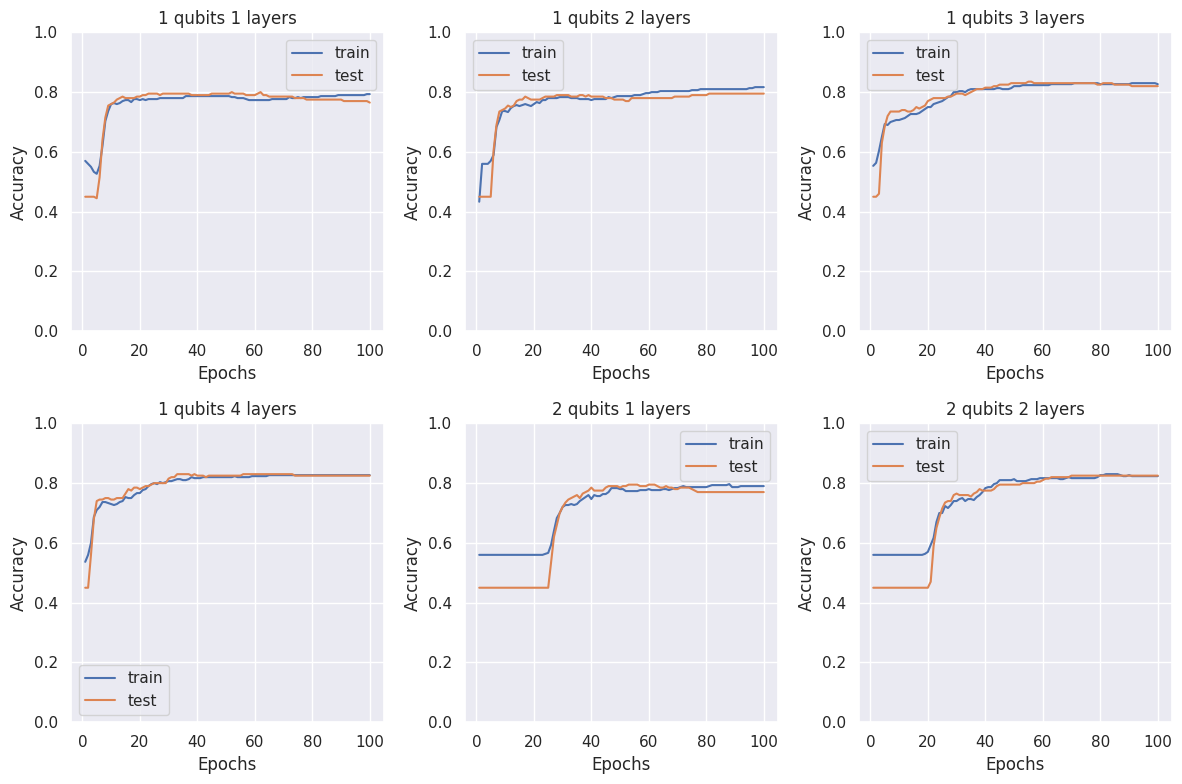

In [56]:
fig, axs = plt.subplots(2,3,figsize=(12,8), dpi=100)

for i in range(2):
    for j in range(3):
        qubits, q_layers = qubits_qlayers[3*i+j]
        axs[i][j].set_title(f'{qubits} qubits {q_layers} layers')
        axs[i][j].set_xlabel('Epochs')
        axs[i][j].set_ylabel('Accuracy')
        axs[i][j].set_ylim(0,1)
        axs[i][j].plot(list(range(1,config['epochs']+1)), result[f'{qubits}q{q_layers}l'][0], label='train')
        axs[i][j].plot(list(range(1,config['epochs']+1)), result[f'{qubits}q{q_layers}l'][1], label='test')
        axs[i][j].legend()
plt.tight_layout()